# Decision Trees Example - Classifying Zoo Animals

### Importing the required packages


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn import tree

### Importing and preprocessing the data

Data sets originally found on Kaggle:

https://www.kaggle.com/datasets/uciml/zoo-animal-classification

https://www.kaggle.com/datasets/agajorte/zoo-animals-extended-dataset

In [2]:
url1 = 'https://raw.githubusercontent.com/Jacob-Gernay/SCP8082660/main/data/zoo.csv'
url2 = 'https://raw.githubusercontent.com/Jacob-Gernay/SCP8082660/main/data/zoo2.csv'
url3 = 'https://raw.githubusercontent.com/Jacob-Gernay/SCP8082660/main/data/zoo3.csv'
url4 = 'https://raw.githubusercontent.com/Jacob-Gernay/SCP8082660/main/data/class.csv'

zoo1 = pd.read_csv(url1)
zoo2 = pd.read_csv(url2)
zoo3 = pd.read_csv(url3)
classnames = pd.read_csv(url4)

zoo = pd.concat([zoo1, zoo2, zoo3], axis=0)
zoo = zoo.set_index('animal_name')
zoo = pd.merge(zoo, classnames[['Class_Number','Class_Type']], how='left', left_on='class_type', right_on='Class_Number')
zoo = zoo.drop(['class_type','Class_Number'], axis=1)
zoo.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,Class_Type
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,Mammal
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,Mammal
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,Fish
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,Mammal
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,Mammal


### Splitting the data into train and test sets

In [3]:
X = zoo.iloc[:, 0:16]
y = zoo['Class_Type']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3)

### Fitting the model

In [4]:
DT= DecisionTreeClassifier(criterion="gini")
DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)

### Visualisation of the fitted tree

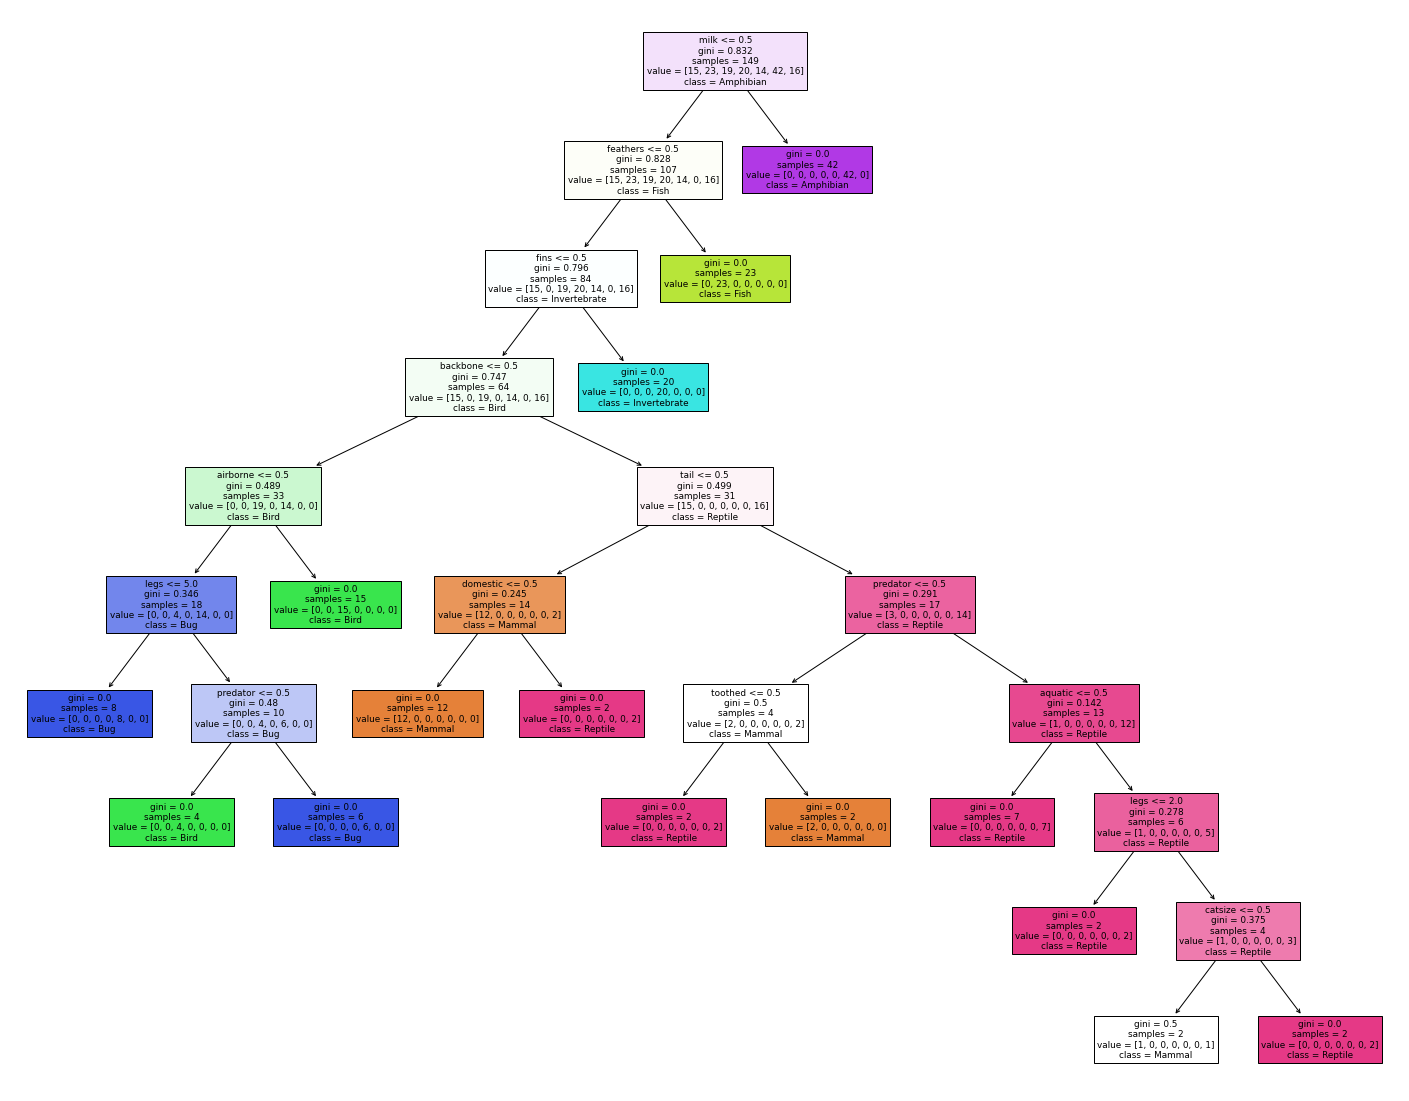

In [5]:
target = list(zoo['Class_Type'].unique())
feature_names = list(X.columns)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DT, 
                   feature_names=feature_names,  
                   class_names=target,
                   filled=True)

### Plotting accurcy vs tree depth to inspect overfitting

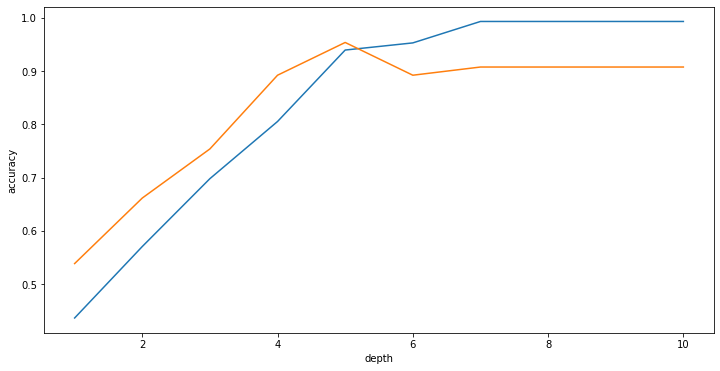

In [6]:
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3)

acc_train_array = []
acc_test_array = []
for depth in range(1,11):
    DT = DecisionTreeClassifier(max_depth = depth)
    DT = DT.fit(X_train, y_train)
    y_train_pred = DT.predict(X_train)
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_train_array.append(acc_train)
    y_pred = DT.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    acc_test_array.append(acc_test)

fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel('depth')
ax.set_ylabel('accuracy')
ax.plot(range(1,11), acc_train_array)
ax.plot(range(1,11), acc_test_array)
plt.show()

## ID3 Algorithm

For the ID3 algorithm I used the code that Riccardo Cappi uploaded on the discussion forum:

https://stem.elearning.unipd.it/mod/forum/discuss.php?d=2484

In [7]:
# Define a hierarchy of classes in order to handle the construction of the Decision Tree
class Node:
  def __init__(self, label, level):
      self.label = label
      self.level = level
      

class InnerNode(Node):
  def __init__(self, label, level,information_gain):
    super(InnerNode, self).__init__(label, level)
    self.subtrees = {}
    self.information_gain = information_gain

  def __str__(self):
    s = self.label + '[ Inf. Gain: '+str(self.information_gain) + ' ]\n'
    offset = ''
    for _ in range(self.level):
      offset += '     '
    for n in self.subtrees.keys():
      s += offset + '|\n' + offset[:-1] + str(n)+'\n' + offset + '|____'  +str(self.subtrees[n])
    return s


class Leaf(Node):
  def __init__(self, label, level):
    super(Leaf, self).__init__(label, level)

  def __str__(self):
    s = str(self.label) + '\n'
    return s

In [8]:
#Entropy
def E(S, classes, column_classes_label):
  entropy = 0
  for c in classes:
    card_Sc = len(S[S[column_classes_label]==c])
    pc = card_Sc / len(S)
    if pc == 1:
      return 0
    if pc == 0:
      continue
    entropy += pc*math.log2(pc)
  return -entropy

#Returns the set of values that a specific argument can have
def get_attribute_value_space(selected_attribute, S):
  values = S[[selected_attribute]].to_numpy().flatten()
  V = list(dict.fromkeys(values))
  return V

#Information Gain
def G(total_entropy, selected_attribute, S, classes, column_classes_label):
  sum = 0
  # Get set of values of 'selected_attribute'
  V = get_attribute_value_space(selected_attribute, S)
  for v in V:
    S_av = S[S[selected_attribute]==v]
    sum += (len(S_av)/len(S)) * E(S_av, classes, column_classes_label)
  return total_entropy - sum

In [9]:
def ID3(total_entropy, S, A, classes, level, column_classes_label):
  if len(A) == 0:
    majority_class = max(classes, key= lambda c: len(S[S[column_classes_label]==c]))
    return Leaf(label=majority_class, level = level)

  if total_entropy == 0:
    return Leaf(label = S[column_classes_label].values[0], level = level)

  print('Total Entropy at level '+ str(level)+': ',str(total_entropy)+ '\n')
  max_gain = np.inf
  t = tuple()
  # Find best attribute
  for a in A:
    a_gain = G(total_entropy, a, S, classes, column_classes_label)
    print(a+'[ Information Gain: ', str(a_gain) + ' ]')
    if (a_gain > max_gain) or (max_gain == np.inf):
      max_gain = a_gain
      t = (a, a_gain)
  
  best_attribute = t[0]
  T = InnerNode(label = best_attribute, level = level, information_gain = t[1])

  ### Printing information
  print('\nBest Attribute:', T)
  print('\n-----------------------------------------\n')
  ###

  A.remove(best_attribute)
  V = get_attribute_value_space(best_attribute, S)
  for v in V:
    S_v = S[S[best_attribute]==v]
    T.subtrees[v] = ID3(E(S_v,classes, column_classes_label), S_v, A.copy(), classes, level+1, column_classes_label)
  return T


def test_ID3(df, A, column_classes_label):
  classes = get_attribute_value_space(column_classes_label, df)
  tot_entropy = E(df, classes, column_classes_label)
  Tree = ID3(tot_entropy, df, A, classes,0, column_classes_label)
  print('Decision Tree representation\n')
  print(Tree)


### ID3 applied to the zoo animal example

In [10]:
zoo.columns

Index(['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator',
       'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail',
       'domestic', 'catsize', 'Class_Type'],
      dtype='object')

In [11]:
DT_ID3 = test_ID3(zoo, ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator',
       'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail',
       'domestic', 'catsize'], 'Class_Type')

Total Entropy at level 0:  2.673579749316558

hair[ Information Gain:  0.6672655398895171 ]
feathers[ Information Gain:  0.6949749673676273 ]
eggs[ Information Gain:  0.7728779339859422 ]
milk[ Information Gain:  0.8559596826463525 ]
airborne[ Information Gain:  0.5234537006362849 ]
aquatic[ Information Gain:  0.4411917733288324 ]
predator[ Information Gain:  0.0641468365663509 ]
toothed[ Information Gain:  0.6781940246520357 ]
backbone[ Information Gain:  0.7420183225388826 ]
breathes[ Information Gain:  0.5238852556661926 ]
venomous[ Information Gain:  0.11635063023930625 ]
fins[ Information Gain:  0.4970272811972487 ]
legs[ Information Gain:  1.4819612194355274 ]
tail[ Information Gain:  0.5688348868354924 ]
domestic[ Information Gain:  0.039336386609116314 ]
catsize[ Information Gain:  0.18196437852338443 ]

Best Attribute: legs[ Inf. Gain: 1.4819612194355274 ]


-----------------------------------------

Total Entropy at level 1:  1.4138057076116106

hair[ Information Gain:  0.961

milk[ Information Gain:  0.0 ]
airborne[ Information Gain:  0.0 ]
predator[ Information Gain:  0.2516291673878229 ]
toothed[ Information Gain:  0.0 ]
backbone[ Information Gain:  0.0 ]
breathes[ Information Gain:  0.0 ]
venomous[ Information Gain:  0.0 ]
fins[ Information Gain:  0.0 ]
domestic[ Information Gain:  0.2516291673878229 ]

Best Attribute: predator[ Inf. Gain: 0.2516291673878229 ]


-----------------------------------------

Total Entropy at level 6:  1.0

feathers[ Information Gain:  0.0 ]
eggs[ Information Gain:  0.0 ]
milk[ Information Gain:  0.0 ]
airborne[ Information Gain:  0.0 ]
toothed[ Information Gain:  0.0 ]
backbone[ Information Gain:  0.0 ]
breathes[ Information Gain:  0.0 ]
venomous[ Information Gain:  0.0 ]
fins[ Information Gain:  0.0 ]
domestic[ Information Gain:  0.0 ]

Best Attribute: feathers[ Inf. Gain: 0.0 ]


-----------------------------------------

Total Entropy at level 7:  1.0

eggs[ Information Gain:  0.0 ]
milk[ Information Gain:  0.0 ]
airborne

Total Entropy at level 5:  0.5916727785823275

feathers[ Information Gain:  0.0 ]
eggs[ Information Gain:  0.0 ]
milk[ Information Gain:  0.0 ]
toothed[ Information Gain:  0.0 ]
backbone[ Information Gain:  0.0 ]
breathes[ Information Gain:  0.0 ]
venomous[ Information Gain:  0.0 ]
fins[ Information Gain:  0.0 ]
tail[ Information Gain:  0.0 ]
domestic[ Information Gain:  0.0 ]
catsize[ Information Gain:  0.0 ]

Best Attribute: feathers[ Inf. Gain: 0.0 ]


-----------------------------------------

Total Entropy at level 6:  0.5916727785823275

eggs[ Information Gain:  0.0 ]
milk[ Information Gain:  0.0 ]
toothed[ Information Gain:  0.0 ]
backbone[ Information Gain:  0.0 ]
breathes[ Information Gain:  0.0 ]
venomous[ Information Gain:  0.0 ]
fins[ Information Gain:  0.0 ]
tail[ Information Gain:  0.0 ]
domestic[ Information Gain:  0.0 ]
catsize[ Information Gain:  0.0 ]

Best Attribute: eggs[ Inf. Gain: 0.0 ]


-----------------------------------------

Total Entropy at level 7:  0.5916